In [63]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [64]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 2 # Plus BOS and EOS markers
BOS_IDX = n_letters - 2
EOS_IDX = n_letters -1

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['English', 'Korean', 'German', 'Scottish', 'Arabic', 'Irish', 'Greek', 'Dutch', 'Portuguese', 'French', 'Polish', 'Russian', 'Spanish', 'Czech', 'Japanese', 'Chinese', 'Italian', 'Vietnamese']
O'Neal


Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt: 





In [65]:
import torch
import torch.nn as nn
from torch.autograd import Variable

torch.set_default_tensor_type('torch.cuda.FloatTensor')
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [66]:
help(nn.LogSoftmax)

Help on class LogSoftmax in module torch.nn.modules.activation:

class LogSoftmax(torch.nn.modules.module.Module)
 |  Applies the Log(Softmax(x)) function to an n-dimensional input Tensor.
 |  The LogSoftmax formulation can be simplified as
 |  
 |  :math:`f_i(x) = log(1 / a * exp(x_i))` where :math:`a = sum_j exp(x_j)`
 |  
 |  Shape:
 |      - Input: :math:`(N, L)`
 |      - Output: :math:`(N, L)`
 |  
 |  Returns:
 |      a Tensor of the same dimension and shape as the input with
 |      values in the range [-inf, 0)
 |  
 |  Examples::
 |  
 |      >>> m = nn.LogSoftmax()
 |      >>> input = autograd.Variable(torch.randn(2, 3))
 |      >>> print(input)
 |      >>> print(m(input))
 |  
 |  Method resolution order:
 |      LogSoftmax
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  forward(self, input)
 |      Defines the computation performed at every call.
 |      
 |      Shoul

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [67]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt: 

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [108]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of BOS to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line) + 1, 1, n_letters)
    tensor[0][0][BOS_IDX] = 1
    for li in range(len(line)):
        letter = line[li]
        tensor[li + 1][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of first letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(c) for c in line]
    letter_indexes.append(EOS_IDX)
    return LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [69]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor
  

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [70]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [71]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [72]:
rnn = RNN(n_letters, 128, n_letters).cuda()

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 33s (5000 5%) 3.0433
1m 7s (10000 10%) 2.7298
1m 41s (15000 15%) 3.1607
2m 14s (20000 20%) 2.9286
2m 48s (25000 25%) 2.0767
3m 21s (30000 30%) 3.0264
3m 55s (35000 35%) 3.0306
4m 27s (40000 40%) 3.1513
5m 0s (45000 45%) 2.1565
5m 33s (50000 50%) 2.3328
6m 6s (55000 55%) 2.4388
6m 38s (60000 60%) 2.2626
7m 11s (65000 65%) 2.4334
7m 44s (70000 70%) 2.7443
8m 16s (75000 75%) 2.2962
8m 49s (80000 80%) 3.3976
9m 23s (85000 85%) 2.3934
9m 58s (90000 90%) 2.8653
10m 33s (95000 95%) 3.1233
11m 8s (100000 100%) 1.6476


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




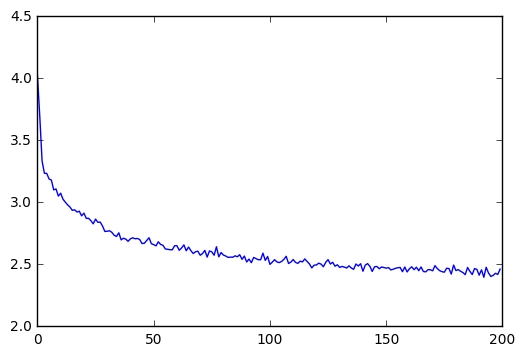

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::  
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [80]:
max_length = 20

# Sample from a category
def sample(category):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(''))
    hidden = rnn.initHidden()

    output_name = ''
    
    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == EOS_IDX:
            break
        else:    
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

# Get multiple samples from one category.
def samples(category, num_samples=5):
    for i in range(num_samples):
        print(sample(category))

samples('Russian')

samples('German')

samples('Spanish')

samples('Chinese')

Variable containing:

Columns 0 to 9 
-6.6042 -6.8814 -6.6292 -6.6829 -6.9223 -6.9599 -6.9298 -6.3494 -7.0585 -7.2064

Columns 10 to 19 
-6.0800 -6.9329 -7.1374 -7.6653 -6.8662 -7.0461 -7.1365 -6.6840 -6.8495 -6.8246

Columns 20 to 29 
-4.6144 -6.2311 -4.6144 -7.1656 -7.2078 -6.6846 -2.6703 -2.6457 -3.1477 -2.9967

Columns 30 to 39 
-4.3167 -3.5511 -3.1327 -3.0275 -4.8210 -3.7789 -2.8656 -3.3340 -2.5076 -3.6512

Columns 40 to 49 
-3.8600 -3.0456 -5.2067 -3.3136 -2.5107 -2.9369 -4.6144 -3.6466 -4.6144 -5.8973

Columns 50 to 59 
-4.3650 -4.1788 -7.0680 -7.0438 -6.9972 -7.1624 -6.9551 -4.6144 -4.6144 -4.6144
[torch.cuda.FloatTensor of size 1x60 (GPU 0)]

Variable containing:

Columns 0 to 9 
-1.9661 -4.1849 -3.5473 -4.8197 -2.9035 -6.0158 -4.7851 -2.6254 -2.9546 -6.5345

Columns 10 to 19 
-4.3837 -3.7022 -5.2770 -4.7736 -2.5114 -5.6638 -6.5765 -3.3328 -3.7781 -3.9611

Columns 20 to 29 
-3.0783 -4.6843 -2.9035 -6.8920 -4.6168 -4.4379 -5.0629 -4.7082 -5.9098 -5.1390

Columns 30 to 39 
-6.24

In [137]:
import numpy as np

def indexToChar(i):
  if i == BOS_IDX:
    return '^'
  elif i == EOS_IDX:
    return '$'
  else:
    return all_letters[i]

def printDistribution(topv, topi):
  topi_np = topi[0].cpu().numpy()
  top_chars = [indexToChar(idx) for idx in topi_np]
  print(topv, top_chars)
  
def sampleNextChar(topv, topi):
  topv_np = topv[0].cpu().numpy()
  topi_np = topi[0].cpu().numpy()
  probs = np.exp(topv_np)
  probs = probs / np.sum(probs)
  choice = np.random.choice(topi_np, p=probs)
  next_char = indexToChar(choice)
  print(topi_np, probs, next_char)
  return next_char
  
def test():
  category = Variable(categoryTensor('English'))
  hidden = rnn.initHidden()
  input = Variable(inputTensor(''))
  for i in range(10):
    output, hidden = rnn(category, input[0], hidden)
    topv, topi = output.data.topk(2)
    # printDistribution(topv, topi)
    next_char = sampleNextChar(topv, topi)
    input = Variable(inputTensor(next_char))
    
test()

[44 38] [ 0.528166  0.471834] S
[4 0] [ 0.52758014  0.47241989] e
[4 0] [ 0.60982651  0.39017352] a
[ 4 17] [ 0.61370879  0.38629121] e
[4 0] [ 0.73814064  0.26185942] e
[ 4 11] [ 0.72212005  0.27787989] e
[ 4 11] [ 0.6719653  0.3280347] e
[ 4 11] [ 0.65685135  0.34314862] e
[ 4 11] [ 0.63897723  0.3610228 ] l
[11 17] [ 0.55359077  0.4464092 ] l


Exercises
=========

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the nn.LSTM and nn.GRU layers
   -  Combine multiple of these RNNs as a higher level network


